In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from os.path import isfile
from datetime import datetime
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Load training and Validation arrays

In [3]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [4]:
npzfile = np.load('data/shuffled_train.npz')
print(npzfile.files)

X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [5]:
y_train = utils.to_categorical(y_train, num_classes=8).astype(int)
print(X_train.shape, y_train.shape)

(6394, 640, 128) (6394, 8)


In [6]:
npzfile = np.load('data/shuffled_valid.npz')
print(npzfile.files)

X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [7]:
y_valid = utils.to_categorical(y_valid, num_classes=8).astype(int)
print(X_valid.shape, y_valid.shape)

(800, 640, 128) (800, 8)


## Check by plotting a Spectogram

Pop


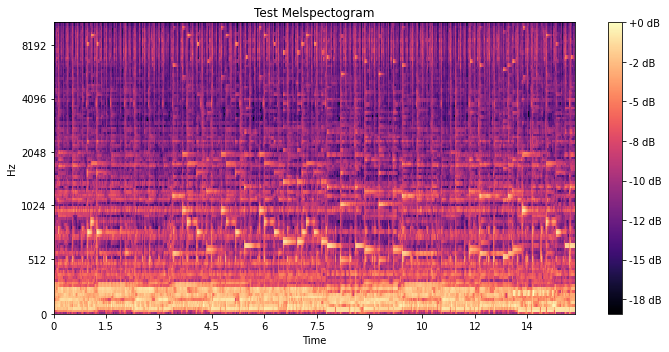

In [8]:
num = 0
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

## Parallel CNN - RNN Model

In [9]:
batch_size = 64
num_classes = 2
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [10]:
nb_filters1=8
nb_filters2=16
nb_filters3=32
nb_filters4=64
ksize = (3,3)
pool_size= (2,2)

EPOCH_COUNT = 30

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1, kernel_initializer = glorot_uniform(seed=9), name='conv_1')(layer)
    batch_1 = BatchNormalization(axis = 3)(conv_1)
    activ_1 = Activation('relu')(batch_1)
    pool_1 = MaxPooling2D(pool_size)(activ_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1, kernel_initializer = glorot_uniform(seed=9), name='conv_2')(pool_1)
    batch_2 = BatchNormalization(axis = 3)(conv_2)
    activ_2 = Activation('relu')(batch_2)
    pool_2 = MaxPooling2D(pool_size)(activ_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1, kernel_initializer = glorot_uniform(seed=9), name='conv_3')(pool_2)
    batch_3 = BatchNormalization(axis = 3)(conv_3)
    activ_3 = Activation('relu')(batch_3)
    pool_3 = MaxPooling2D(pool_size)(activ_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1, kernel_initializer = glorot_uniform(seed=9), name='conv_4')(pool_3)
    batch_4 = BatchNormalization(axis = 3)(conv_4)
    activ_4 = Activation('relu')(batch_4)
    pool_4 = MaxPooling2D(pool_size)(activ_4)
    
    flatten1 = Flatten()(pool_4)
    
    output = Dense(num_classes, activation = 'softmax', name='preds', kernel_initializer = glorot_uniform(seed=9))(flatten1)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(learning_rate=0.00005)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [11]:
def train_model(x_train, y_train, x_val, y_val, info = "", genres_name = ""):
    n_frames = 640
    n_frequency = 128
    
    #reshape and expand dims for conv2d
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
       
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    log_dir = "./logs/tree_6/model_root/"+datetime.now().strftime("%Y%m%d-%H%M%S_")+info
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False, update_freq='batch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None)

    model_folder = "./models/tree_6/model_root/{}".format(info)
    os.makedirs(model_folder, exist_ok=True)
    
    f = open("{}/info.txt".format(model_folder), "w")
    f.write("genre name split: {}".format(genres_name))
    checkpoint_callback = ModelCheckpoint('{}/model.h5'.format(model_folder), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1)
    callbacks_list = [tb_callback, checkpoint_callback, reducelr_callback]
    
    f.close()
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=EPOCH_COUNT, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)
    
    return model, history

In [12]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [13]:
def create_split(elem, c):
    splits = []
    for i in range(c):
        equal = False
        np.random.shuffle(elem)
        new_split = list(chunks(elem, int(len(elem)/2)))
        for split in splits:
            if set(new_split[0]) == set(split[0]) and set(new_split[0]) == set(split[1]):
                equal = True
                break
            
        if equal:
            i-=1
            continue
        
        splits.append(new_split)
        
    return splits

In [14]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Folder num 1
Genre split [['Experimental', 'International', 'Folk', 'Rock'], ['Hip-Hop', 'Electronic', 'Instrumental', 'Pop']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 19s 72ms/step - loss: 0.8005 - accuracy: 0.5452 - val_loss: 0.7817 - val_accuracy: 0.4709

Epoch 00001: val_accuracy improved from -inf to 0.47087, saving model to ./models/tree_6/model_root/folder1\model.h5
Epoch 2/30
110/110 [==============================] - 7s 62ms/step - loss: 0.6988 - accuracy: 0.6100 - val_loss: 0.8077 - val_accuracy: 0.4951

Epoch 00002: val_accuracy improved from 0.47087 to 0.49515, saving model to ./models/tree_6/model_root/folder1\model.h5
Epoch 3/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6481 - accuracy: 0.6422 - val_loss: 0.7890 - val_accuracy: 0.5534

Epoch 00003: val_accuracy improved from 0.49515 to 0.55340, saving model to ./models/tree_6/model_root/folder1\model.h5
Epoch 4/30
110/110 [==============================] -

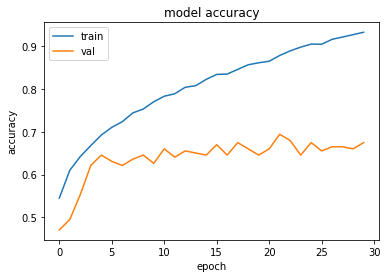

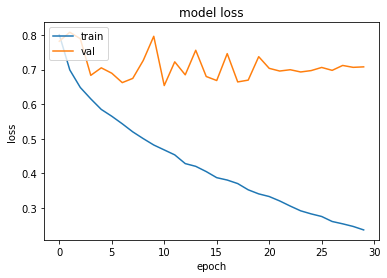

Folder num 2
Genre split [['Instrumental', 'Rock', 'Hip-Hop', 'Folk'], ['Electronic', 'Pop', 'Experimental', 'International']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 16s 132ms/step - loss: 0.7906 - accuracy: 0.5525 - val_loss: 0.7917 - val_accuracy: 0.4951

Epoch 00001: val_accuracy improved from -inf to 0.49515, saving model to ./models/tree_6/model_root/folder2\model.h5
Epoch 2/30
110/110 [==============================] - 7s 65ms/step - loss: 0.7115 - accuracy: 0.5966 - val_loss: 0.7077 - val_accuracy: 0.6117

Epoch 00002: val_accuracy improved from 0.49515 to 0.61165, saving model to ./models/tree_6/model_root/folder2\model.h5
Epoch 3/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6540 - accuracy: 0.6415 - val_loss: 0.6956 - val_accuracy: 0.6505

Epoch 00003: val_accuracy improved from 0.61165 to 0.65049, saving model to ./models/tree_6/model_root/folder2\model.h5
Epoch 4/30
110/110 [==============================] 

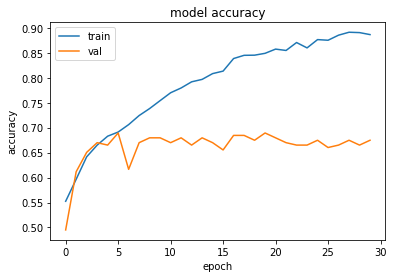

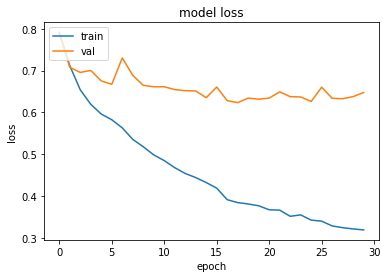

Folder num 3
Genre split [['Hip-Hop', 'International', 'Pop', 'Electronic'], ['Experimental', 'Rock', 'Folk', 'Instrumental']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 9s 71ms/step - loss: 0.6896 - accuracy: 0.6570 - val_loss: 0.7692 - val_accuracy: 0.5583

Epoch 00001: val_accuracy improved from -inf to 0.55825, saving model to ./models/tree_6/model_root/folder3\model.h5
Epoch 2/30
110/110 [==============================] - 7s 66ms/step - loss: 0.5813 - accuracy: 0.7167 - val_loss: 0.6934 - val_accuracy: 0.6359

Epoch 00002: val_accuracy improved from 0.55825 to 0.63592, saving model to ./models/tree_6/model_root/folder3\model.h5
Epoch 3/30
110/110 [==============================] - 7s 67ms/step - loss: 0.5509 - accuracy: 0.7386 - val_loss: 0.6722 - val_accuracy: 0.6602

Epoch 00003: val_accuracy improved from 0.63592 to 0.66019, saving model to ./models/tree_6/model_root/folder3\model.h5
Epoch 4/30
110/110 [==============================] - 

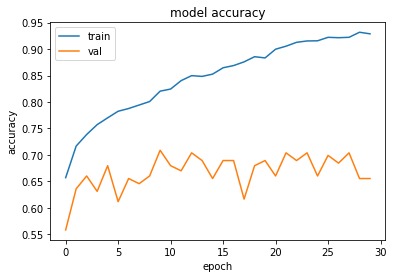

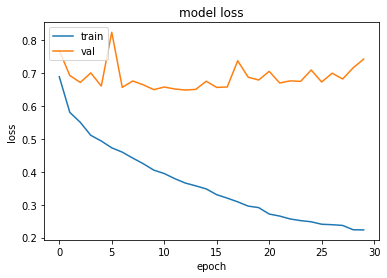

Folder num 4
Genre split [['Electronic', 'Folk', 'Instrumental', 'Hip-Hop'], ['Experimental', 'Pop', 'International', 'Rock']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 22s 66ms/step - loss: 0.7703 - accuracy: 0.6003 - val_loss: 0.6928 - val_accuracy: 0.5922

Epoch 00001: val_accuracy improved from -inf to 0.59223, saving model to ./models/tree_6/model_root/folder4\model.h5
Epoch 2/30
110/110 [==============================] - 7s 62ms/step - loss: 0.6707 - accuracy: 0.6435 - val_loss: 0.6812 - val_accuracy: 0.5631

Epoch 00002: val_accuracy did not improve from 0.59223
Epoch 3/30
110/110 [==============================] - 9s 79ms/step - loss: 0.6250 - accuracy: 0.6737 - val_loss: 0.6697 - val_accuracy: 0.5971

Epoch 00003: val_accuracy improved from 0.59223 to 0.59709, saving model to ./models/tree_6/model_root/folder4\model.h5
Epoch 4/30
110/110 [==============================] - 7s 68ms/step - loss: 0.6019 - accuracy: 0.6867 - val_loss: 0.658

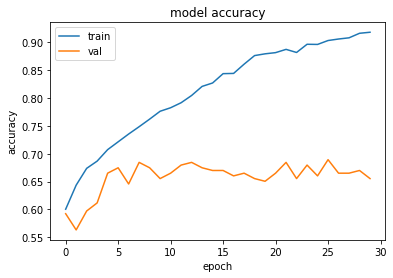

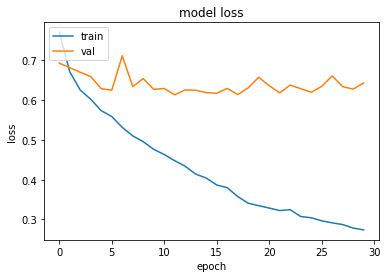

Folder num 5
Genre split [['Electronic', 'Instrumental', 'International', 'Folk'], ['Rock', 'Pop', 'Experimental', 'Hip-Hop']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 9s 70ms/step - loss: 0.7537 - accuracy: 0.6156 - val_loss: 0.6615 - val_accuracy: 0.6165

Epoch 00001: val_accuracy improved from -inf to 0.61650, saving model to ./models/tree_6/model_root/folder5\model.h5
Epoch 2/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6574 - accuracy: 0.6548 - val_loss: 0.6290 - val_accuracy: 0.6019

Epoch 00002: val_accuracy did not improve from 0.61650
Epoch 3/30
110/110 [==============================] - 10s 94ms/step - loss: 0.6143 - accuracy: 0.6825 - val_loss: 0.6118 - val_accuracy: 0.6699

Epoch 00003: val_accuracy improved from 0.61650 to 0.66990, saving model to ./models/tree_6/model_root/folder5\model.h5
Epoch 4/30
110/110 [==============================] - 7s 63ms/step - loss: 0.5912 - accuracy: 0.6998 - val_loss: 0.628

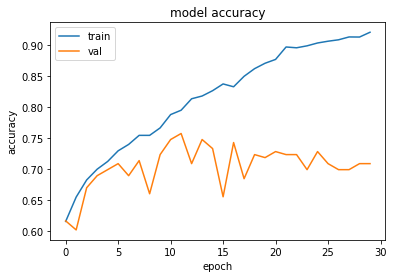

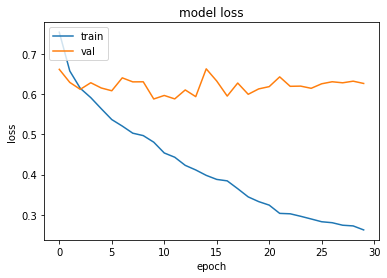

Folder num 6
Genre split [['Instrumental', 'Electronic', 'Rock', 'Experimental'], ['Hip-Hop', 'Folk', 'Pop', 'International']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 9s 71ms/step - loss: 0.7577 - accuracy: 0.6055 - val_loss: 0.9505 - val_accuracy: 0.4854

Epoch 00001: val_accuracy improved from -inf to 0.48544, saving model to ./models/tree_6/model_root/folder6\model.h5
Epoch 2/30
110/110 [==============================] - 9s 84ms/step - loss: 0.6335 - accuracy: 0.6777 - val_loss: 0.8543 - val_accuracy: 0.5291

Epoch 00002: val_accuracy improved from 0.48544 to 0.52913, saving model to ./models/tree_6/model_root/folder6\model.h5
Epoch 3/30
110/110 [==============================] - 8s 68ms/step - loss: 0.5966 - accuracy: 0.6976 - val_loss: 0.5797 - val_accuracy: 0.6602

Epoch 00003: val_accuracy improved from 0.52913 to 0.66019, saving model to ./models/tree_6/model_root/folder6\model.h5
Epoch 4/30
110/110 [==============================] - 

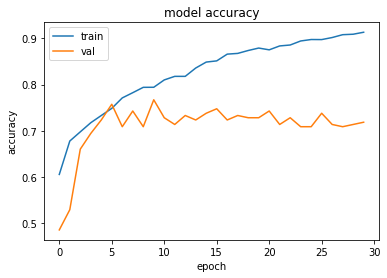

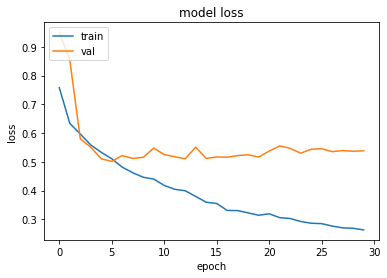

Folder num 7
Genre split [['Folk', 'Electronic', 'International', 'Instrumental'], ['Rock', 'Pop', 'Hip-Hop', 'Experimental']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 14s 118ms/step - loss: 0.7507 - accuracy: 0.6161 - val_loss: 0.6609 - val_accuracy: 0.5922

Epoch 00001: val_accuracy improved from -inf to 0.59223, saving model to ./models/tree_6/model_root/folder7\model.h5
Epoch 2/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6645 - accuracy: 0.6556 - val_loss: 0.6171 - val_accuracy: 0.6893

Epoch 00002: val_accuracy improved from 0.59223 to 0.68932, saving model to ./models/tree_6/model_root/folder7\model.h5
Epoch 3/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6316 - accuracy: 0.6722 - val_loss: 0.6163 - val_accuracy: 0.7039

Epoch 00003: val_accuracy improved from 0.68932 to 0.70388, saving model to ./models/tree_6/model_root/folder7\model.h5
Epoch 4/30
110/110 [==============================] 

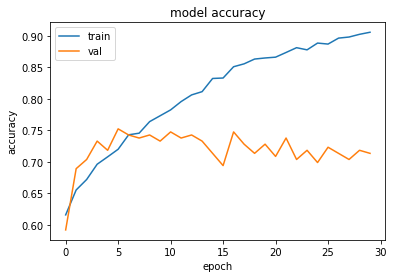

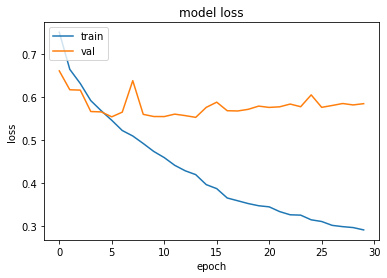

Folder num 8
Genre split [['Hip-Hop', 'Electronic', 'Pop', 'International'], ['Rock', 'Experimental', 'Instrumental', 'Folk']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 11s 66ms/step - loss: 0.7009 - accuracy: 0.6511 - val_loss: 0.7984 - val_accuracy: 0.4417

Epoch 00001: val_accuracy improved from -inf to 0.44175, saving model to ./models/tree_6/model_root/folder8\model.h5
Epoch 2/30
110/110 [==============================] - 7s 63ms/step - loss: 0.5914 - accuracy: 0.7085 - val_loss: 0.7391 - val_accuracy: 0.5485

Epoch 00002: val_accuracy improved from 0.44175 to 0.54854, saving model to ./models/tree_6/model_root/folder8\model.h5
Epoch 3/30
110/110 [==============================] - 7s 63ms/step - loss: 0.5514 - accuracy: 0.7341 - val_loss: 0.6397 - val_accuracy: 0.6942

Epoch 00003: val_accuracy improved from 0.54854 to 0.69417, saving model to ./models/tree_6/model_root/folder8\model.h5
Epoch 4/30
110/110 [==============================] -

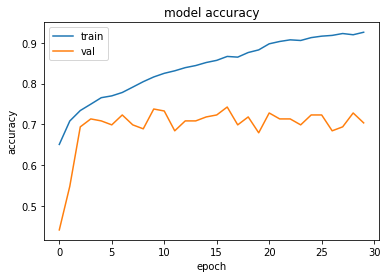

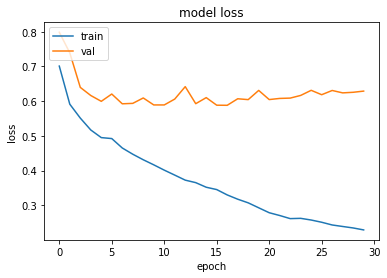

Folder num 9
Genre split [['Electronic', 'Hip-Hop', 'Rock', 'Pop'], ['International', 'Instrumental', 'Experimental', 'Folk']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 9s 67ms/step - loss: 0.7355 - accuracy: 0.6262 - val_loss: 0.6695 - val_accuracy: 0.5777

Epoch 00001: val_accuracy improved from -inf to 0.57767, saving model to ./models/tree_6/model_root/folder9\model.h5
Epoch 2/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6326 - accuracy: 0.6727 - val_loss: 0.6483 - val_accuracy: 0.6068

Epoch 00002: val_accuracy improved from 0.57767 to 0.60680, saving model to ./models/tree_6/model_root/folder9\model.h5
Epoch 3/30
110/110 [==============================] - 7s 63ms/step - loss: 0.5968 - accuracy: 0.6982 - val_loss: 0.6515 - val_accuracy: 0.6796

Epoch 00003: val_accuracy improved from 0.60680 to 0.67961, saving model to ./models/tree_6/model_root/folder9\model.h5
Epoch 4/30
110/110 [==============================] - 

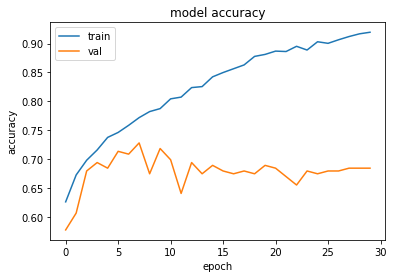

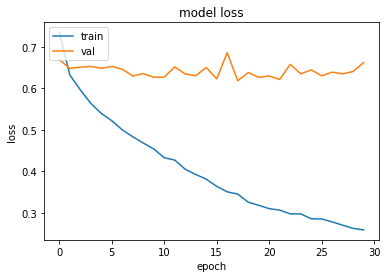

Folder num 10
Genre split [['Hip-Hop', 'Electronic', 'Instrumental', 'International'], ['Experimental', 'Folk', 'Rock', 'Pop']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 9s 67ms/step - loss: 0.7821 - accuracy: 0.5839 - val_loss: 0.6456 - val_accuracy: 0.6359

Epoch 00001: val_accuracy improved from -inf to 0.63592, saving model to ./models/tree_6/model_root/folder10\model.h5
Epoch 2/30
110/110 [==============================] - 7s 62ms/step - loss: 0.6626 - accuracy: 0.6487 - val_loss: 0.6893 - val_accuracy: 0.5825

Epoch 00002: val_accuracy did not improve from 0.63592
Epoch 3/30
110/110 [==============================] - 7s 62ms/step - loss: 0.6259 - accuracy: 0.6733 - val_loss: 0.6296 - val_accuracy: 0.6456

Epoch 00003: val_accuracy improved from 0.63592 to 0.64563, saving model to ./models/tree_6/model_root/folder10\model.h5
Epoch 4/30
110/110 [==============================] - 7s 63ms/step - loss: 0.5833 - accuracy: 0.7021 - val_loss: 0.6

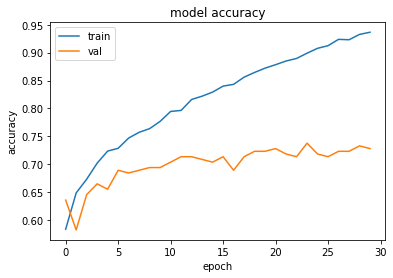

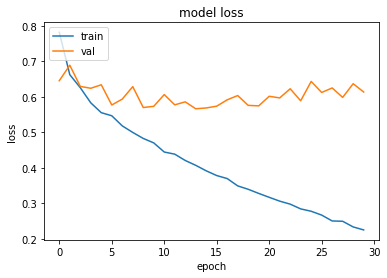

Folder num 11
Genre split [['Electronic', 'International', 'Hip-Hop', 'Folk'], ['Rock', 'Instrumental', 'Experimental', 'Pop']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 18s 151ms/step - loss: 0.6957 - accuracy: 0.6507 - val_loss: 0.6784 - val_accuracy: 0.5485

Epoch 00001: val_accuracy improved from -inf to 0.54854, saving model to ./models/tree_6/model_root/folder11\model.h5
Epoch 2/30
110/110 [==============================] - 7s 62ms/step - loss: 0.6105 - accuracy: 0.6981 - val_loss: 0.6665 - val_accuracy: 0.5971

Epoch 00002: val_accuracy improved from 0.54854 to 0.59709, saving model to ./models/tree_6/model_root/folder11\model.h5
Epoch 3/30
110/110 [==============================] - 7s 62ms/step - loss: 0.5763 - accuracy: 0.7141 - val_loss: 0.5621 - val_accuracy: 0.6942

Epoch 00003: val_accuracy improved from 0.59709 to 0.69417, saving model to ./models/tree_6/model_root/folder11\model.h5
Epoch 4/30
110/110 [============================

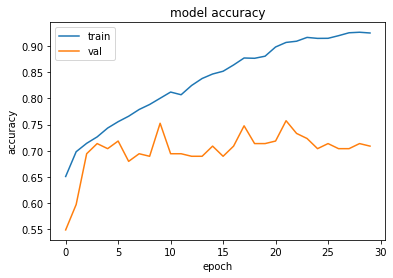

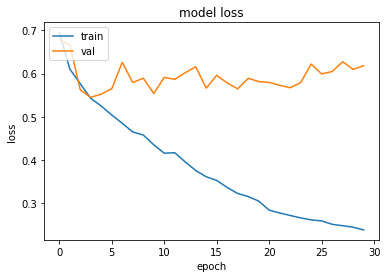

Folder num 12
Genre split [['Electronic', 'Experimental', 'Pop', 'Folk'], ['Instrumental', 'International', 'Hip-Hop', 'Rock']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 8s 66ms/step - loss: 0.8368 - accuracy: 0.5187 - val_loss: 0.7828 - val_accuracy: 0.4903

Epoch 00001: val_accuracy improved from -inf to 0.49029, saving model to ./models/tree_6/model_root/folder12\model.h5
Epoch 2/30
110/110 [==============================] - 7s 63ms/step - loss: 0.7405 - accuracy: 0.5645 - val_loss: 0.7696 - val_accuracy: 0.51944

Epoch 00002: val_accuracy improved from 0.49029 to 0.51942, saving model to ./models/tree_6/model_root/folder12\model.h5
Epoch 3/30
110/110 [==============================] - 7s 62ms/step - loss: 0.6982 - accuracy: 0.5952 - val_loss: 0.7417 - val_accuracy: 0.5583

Epoch 00003: val_accuracy improved from 0.51942 to 0.55825, saving model to ./models/tree_6/model_root/folder12\model.h5
Epoch 4/30
110/110 [=============================

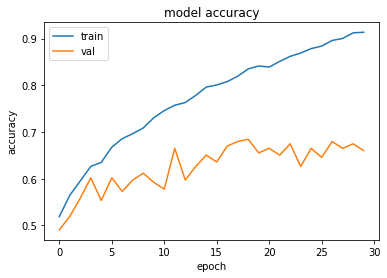

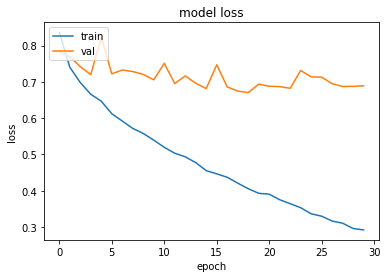

Folder num 13
Genre split [['Experimental', 'Instrumental', 'Folk', 'Rock'], ['Hip-Hop', 'International', 'Pop', 'Electronic']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 9s 68ms/step - loss: 0.7099 - accuracy: 0.6372 - val_loss: 1.1052 - val_accuracy: 0.4515

Epoch 00001: val_accuracy improved from -inf to 0.45146, saving model to ./models/tree_6/model_root/folder13\model.h5
Epoch 2/30
110/110 [==============================] - 7s 63ms/step - loss: 0.5892 - accuracy: 0.7125 - val_loss: 1.1442 - val_accuracy: 0.4660

Epoch 00002: val_accuracy improved from 0.45146 to 0.46602, saving model to ./models/tree_6/model_root/folder13\model.h5
Epoch 3/30
110/110 [==============================] - 7s 63ms/step - loss: 0.5567 - accuracy: 0.7271 - val_loss: 0.8761 - val_accuracy: 0.5485

Epoch 00003: val_accuracy improved from 0.46602 to 0.54854, saving model to ./models/tree_6/model_root/folder13\model.h5
Epoch 4/30
110/110 [==============================

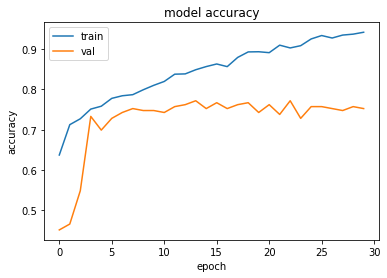

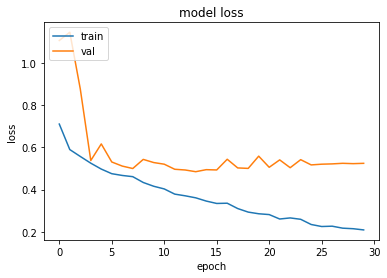

Folder num 14
Genre split [['Rock', 'Folk', 'International', 'Pop'], ['Instrumental', 'Experimental', 'Electronic', 'Hip-Hop']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 9s 67ms/step - loss: 0.7710 - accuracy: 0.5843 - val_loss: 0.7037 - val_accuracy: 0.5388

Epoch 00001: val_accuracy improved from -inf to 0.53883, saving model to ./models/tree_6/model_root/folder14\model.h5
Epoch 2/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6537 - accuracy: 0.6480 - val_loss: 0.6378 - val_accuracy: 0.597137 - accuracy: 0.

Epoch 00002: val_accuracy improved from 0.53883 to 0.59709, saving model to ./models/tree_6/model_root/folder14\model.h5
Epoch 3/30
110/110 [==============================] - 8s 75ms/step - loss: 0.6125 - accuracy: 0.6800 - val_loss: 0.6264 - val_accuracy: 0.6650

Epoch 00003: val_accuracy improved from 0.59709 to 0.66505, saving model to ./models/tree_6/model_root/folder14\model.h5
Epoch 4/30
110/110 [=============

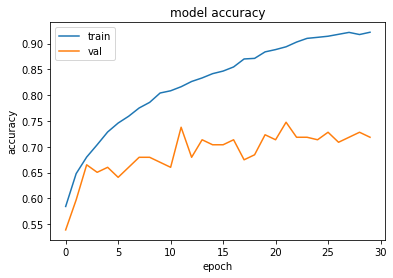

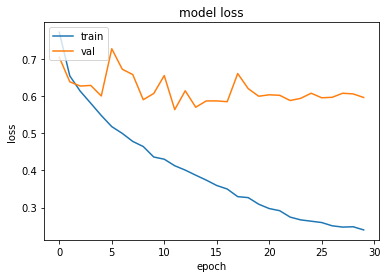

Folder num 15
Genre split [['Electronic', 'Hip-Hop', 'Experimental', 'Instrumental'], ['International', 'Folk', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 11s 65ms/step - loss: 0.8198 - accuracy: 0.5488 - val_loss: 0.7145 - val_accuracy: 0.5049

Epoch 00001: val_accuracy improved from -inf to 0.50485, saving model to ./models/tree_6/model_root/folder15\model.h5
Epoch 2/30
110/110 [==============================] - 7s 62ms/step - loss: 0.6892 - accuracy: 0.6214 - val_loss: 0.6269 - val_accuracy: 0.6311

Epoch 00002: val_accuracy improved from 0.50485 to 0.63107, saving model to ./models/tree_6/model_root/folder15\model.h5
Epoch 3/30
110/110 [==============================] - 7s 62ms/step - loss: 0.6271 - accuracy: 0.6674 - val_loss: 0.6040 - val_accuracy: 0.6748

Epoch 00003: val_accuracy improved from 0.63107 to 0.67476, saving model to ./models/tree_6/model_root/folder15\model.h5
Epoch 4/30
110/110 [=============================

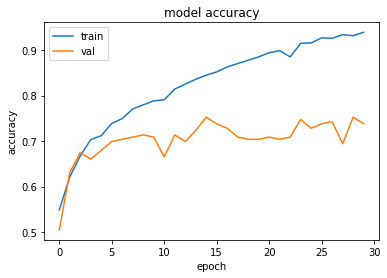

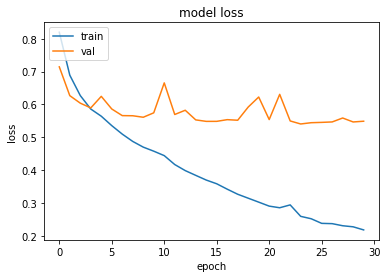

Folder num 16
Genre split [['Electronic', 'Rock', 'Hip-Hop', 'Folk'], ['Experimental', 'Instrumental', 'Pop', 'International']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 9s 67ms/step - loss: 0.7918 - accuracy: 0.5611 - val_loss: 0.6961 - val_accuracy: 0.5534

Epoch 00001: val_accuracy improved from -inf to 0.55340, saving model to ./models/tree_6/model_root/folder16\model.h5
Epoch 2/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6891 - accuracy: 0.6183 - val_loss: 0.7106 - val_accuracy: 0.5340

Epoch 00002: val_accuracy did not improve from 0.55340
Epoch 3/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6576 - accuracy: 0.6448 - val_loss: 0.6721 - val_accuracy: 0.6165

Epoch 00003: val_accuracy improved from 0.55340 to 0.61650, saving model to ./models/tree_6/model_root/folder16\model.h5
Epoch 4/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6204 - accuracy: 0.6639 - val_loss: 0.6

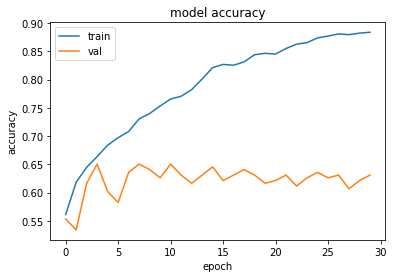

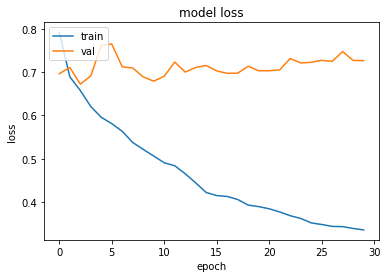

Folder num 17
Genre split [['Experimental', 'International', 'Pop', 'Hip-Hop'], ['Electronic', 'Folk', 'Instrumental', 'Rock']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 9s 68ms/step - loss: 0.8040 - accuracy: 0.5645 - val_loss: 0.7260 - val_accuracy: 0.4757

Epoch 00001: val_accuracy improved from -inf to 0.47573, saving model to ./models/tree_6/model_root/folder17\model.h5
Epoch 2/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6822 - accuracy: 0.6193 - val_loss: 0.6737 - val_accuracy: 0.6214

Epoch 00002: val_accuracy improved from 0.47573 to 0.62136, saving model to ./models/tree_6/model_root/folder17\model.h5
Epoch 3/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6400 - accuracy: 0.6511 - val_loss: 0.6634 - val_accuracy: 0.6602

Epoch 00003: val_accuracy improved from 0.62136 to 0.66019, saving model to ./models/tree_6/model_root/folder17\model.h5
Epoch 4/30
110/110 [==============================

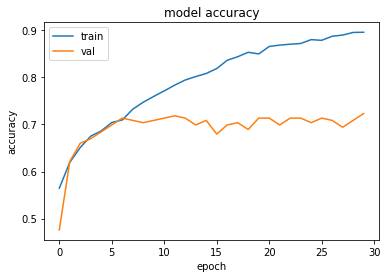

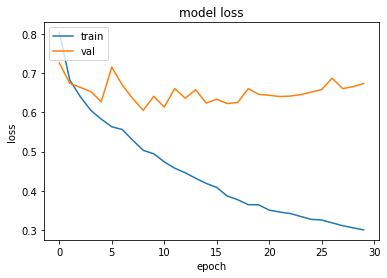

Folder num 18
Genre split [['International', 'Hip-Hop', 'Rock', 'Instrumental'], ['Folk', 'Pop', 'Experimental', 'Electronic']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 9s 68ms/step - loss: 0.8376 - accuracy: 0.5225 - val_loss: 0.7216 - val_accuracy: 0.4854

Epoch 00001: val_accuracy improved from -inf to 0.48544, saving model to ./models/tree_6/model_root/folder18\model.h5
Epoch 2/30
110/110 [==============================] - 7s 63ms/step - loss: 0.7399 - accuracy: 0.5677 - val_loss: 0.7250 - val_accuracy: 0.5000

Epoch 00002: val_accuracy improved from 0.48544 to 0.50000, saving model to ./models/tree_6/model_root/folder18\model.h5
Epoch 3/30
110/110 [==============================] - 7s 62ms/step - loss: 0.6922 - accuracy: 0.6013 - val_loss: 0.7406 - val_accuracy: 0.5777

Epoch 00003: val_accuracy improved from 0.50000 to 0.57767, saving model to ./models/tree_6/model_root/folder18\model.h5
Epoch 4/30
110/110 [==============================

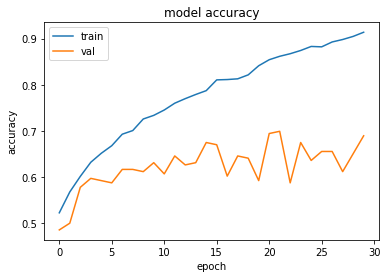

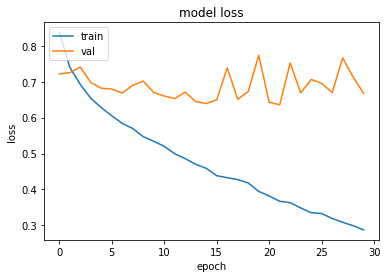

Folder num 19
Genre split [['Experimental', 'Folk', 'Hip-Hop', 'Instrumental'], ['Rock', 'International', 'Pop', 'Electronic']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 8s 66ms/step - loss: 0.7795 - accuracy: 0.5893 - val_loss: 0.8452 - val_accuracy: 0.5097

Epoch 00001: val_accuracy improved from -inf to 0.50971, saving model to ./models/tree_6/model_root/folder19\model.h5
Epoch 2/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6918 - accuracy: 0.6219 - val_loss: 0.7873 - val_accuracy: 0.5388

Epoch 00002: val_accuracy improved from 0.50971 to 0.53883, saving model to ./models/tree_6/model_root/folder19\model.h5
Epoch 3/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6472 - accuracy: 0.6501 - val_loss: 0.6508 - val_accuracy: 0.6650

Epoch 00003: val_accuracy improved from 0.53883 to 0.66505, saving model to ./models/tree_6/model_root/folder19\model.h5
Epoch 4/30
110/110 [==============================

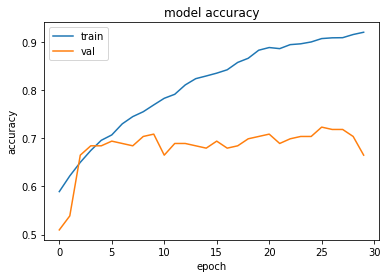

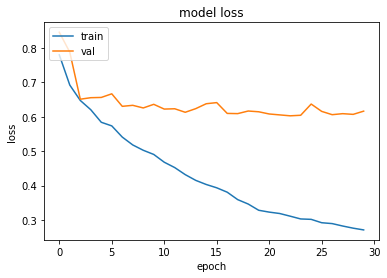

Folder num 20
Genre split [['Folk', 'Electronic', 'Pop', 'Experimental'], ['Hip-Hop', 'Instrumental', 'International', 'Rock']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 9s 71ms/step - loss: 0.8340 - accuracy: 0.5244 - val_loss: 0.7422 - val_accuracy: 0.5073

Epoch 00001: val_accuracy improved from -inf to 0.50732, saving model to ./models/tree_6/model_root/folder20\model.h5
Epoch 2/30
110/110 [==============================] - 7s 63ms/step - loss: 0.7481 - accuracy: 0.5632 - val_loss: 0.7384 - val_accuracy: 0.5268

Epoch 00002: val_accuracy improved from 0.50732 to 0.52683, saving model to ./models/tree_6/model_root/folder20\model.h5
Epoch 3/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6907 - accuracy: 0.6031 - val_loss: 0.7646 - val_accuracy: 0.5756

Epoch 00003: val_accuracy improved from 0.52683 to 0.57561, saving model to ./models/tree_6/model_root/folder20\model.h5
Epoch 4/30
110/110 [==============================

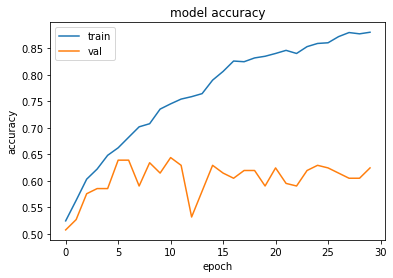

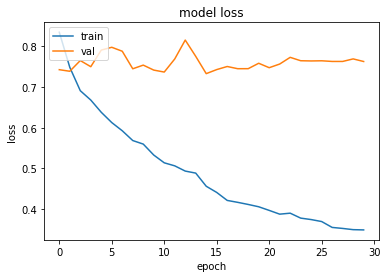

Folder num 21
Genre split [['Pop', 'Rock', 'Electronic', 'Hip-Hop'], ['Experimental', 'International', 'Folk', 'Instrumental']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 9s 69ms/step - loss: 0.7444 - accuracy: 0.6220 - val_loss: 0.7151 - val_accuracy: 0.5171- l

Epoch 00001: val_accuracy improved from -inf to 0.51707, saving model to ./models/tree_6/model_root/folder21\model.h5
Epoch 2/30
110/110 [==============================] - 9s 83ms/step - loss: 0.6285 - accuracy: 0.6784 - val_loss: 0.6973 - val_accuracy: 0.5951

Epoch 00002: val_accuracy improved from 0.51707 to 0.59512, saving model to ./models/tree_6/model_root/folder21\model.h5
Epoch 3/30
110/110 [==============================] - 7s 65ms/step - loss: 0.5938 - accuracy: 0.6992 - val_loss: 0.6364 - val_accuracy: 0.6927

Epoch 00003: val_accuracy improved from 0.59512 to 0.69268, saving model to ./models/tree_6/model_root/folder21\model.h5
Epoch 4/30
110/110 [===========================

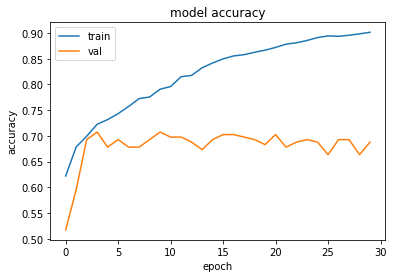

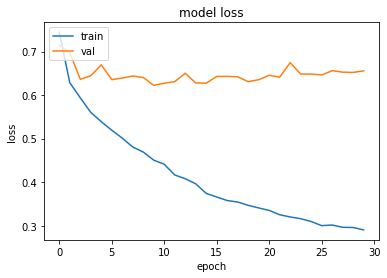

Folder num 22
Genre split [['Folk', 'Experimental', 'Hip-Hop', 'Instrumental'], ['Electronic', 'International', 'Rock', 'Pop']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 11s 90ms/step - loss: 0.7890 - accuracy: 0.5886 - val_loss: 0.8559 - val_accuracy: 0.5220

Epoch 00001: val_accuracy improved from -inf to 0.52195, saving model to ./models/tree_6/model_root/folder22\model.h5
Epoch 2/30
110/110 [==============================] - 7s 63ms/step - loss: 0.7030 - accuracy: 0.6217 - val_loss: 0.6835 - val_accuracy: 0.6146

Epoch 00002: val_accuracy improved from 0.52195 to 0.61463, saving model to ./models/tree_6/model_root/folder22\model.h5
Epoch 3/30
110/110 [==============================] - 7s 62ms/step - loss: 0.6465 - accuracy: 0.6536 - val_loss: 0.6220 - val_accuracy: 0.6683

Epoch 00003: val_accuracy improved from 0.61463 to 0.66829, saving model to ./models/tree_6/model_root/folder22\model.h5
Epoch 4/30
110/110 [=============================

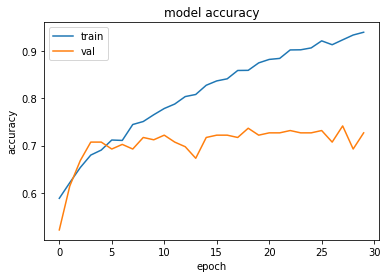

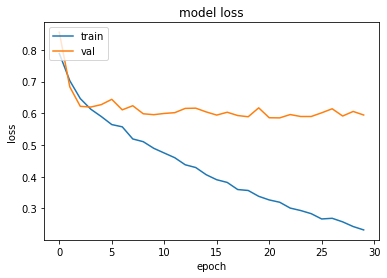

Folder num 23
Genre split [['Folk', 'Hip-Hop', 'International', 'Experimental'], ['Rock', 'Pop', 'Electronic', 'Instrumental']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 9s 67ms/step - loss: 0.7797 - accuracy: 0.5781 - val_loss: 0.7007 - val_accuracy: 0.5268

Epoch 00001: val_accuracy improved from -inf to 0.52683, saving model to ./models/tree_6/model_root/folder23\model.h5
Epoch 2/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6836 - accuracy: 0.6214 - val_loss: 0.6582 - val_accuracy: 0.6244

Epoch 00002: val_accuracy improved from 0.52683 to 0.62439, saving model to ./models/tree_6/model_root/folder23\model.h5
Epoch 3/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6435 - accuracy: 0.6567 - val_loss: 0.6364 - val_accuracy: 0.6439

Epoch 00003: val_accuracy improved from 0.62439 to 0.64390, saving model to ./models/tree_6/model_root/folder23\model.h5
Epoch 4/30
110/110 [==============================

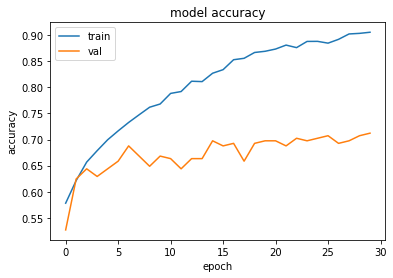

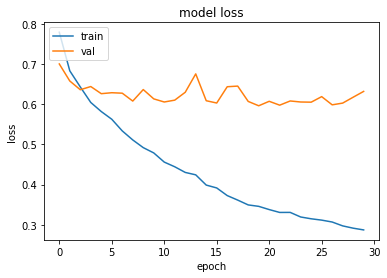

Folder num 24
Genre split [['Instrumental', 'Experimental', 'Electronic', 'International'], ['Folk', 'Pop', 'Hip-Hop', 'Rock']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 9s 67ms/step - loss: 0.8175 - accuracy: 0.5413 - val_loss: 0.7790 - val_accuracy: 0.4878

Epoch 00001: val_accuracy improved from -inf to 0.48780, saving model to ./models/tree_6/model_root/folder24\model.h5
Epoch 2/30
110/110 [==============================] - 7s 62ms/step - loss: 0.6754 - accuracy: 0.6261 - val_loss: 0.7608 - val_accuracy: 0.5317

Epoch 00002: val_accuracy improved from 0.48780 to 0.53171, saving model to ./models/tree_6/model_root/folder24\model.h5
Epoch 3/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6230 - accuracy: 0.6726 - val_loss: 0.7377 - val_accuracy: 0.5561

Epoch 00003: val_accuracy improved from 0.53171 to 0.55610, saving model to ./models/tree_6/model_root/folder24\model.h5
Epoch 4/30
110/110 [==============================

In [ ]:
X_train_cross = np.concatenate((X_train, X_valid), axis=0)
y_train_cross = np.concatenate((y_train, y_valid), axis=0)

num_splits = 35

kfold = KFold(n_splits=35, shuffle=True)
genre_splits = create_split(list(dict_genres.values()), num_splits)

fold_no = 1
for train, test in kfold.split(X_train_cross, y_train_cross):
    split = genre_splits[fold_no - 1]
    
    y_train_cross_binary = np.argmax(y_train_cross, axis=1)
    y_train_cross_binary = np.in1d(y_train_cross_binary, split[0])
    y_train_cross_binary = utils.to_categorical(y_train_cross_binary*1, num_classes=2)
    
    print("Folder num {}".format(fold_no))
    genres_name = [[reverse_map[g] for g in split_l] for split_l in split]
    print("Genre split {}".format(genres_name))
    
    model, history  = train_model(X_train_cross[train], y_train_cross_binary[train], X_train_cross[test], y_train_cross_binary[test], "folder{}".format(fold_no), genres_name)
    show_summary_stats(history)
    
    fold_no += 1
    if fold_no > num_splits:
        break